<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[05:10:12] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


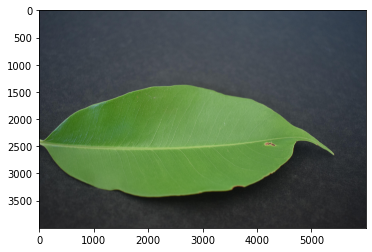

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

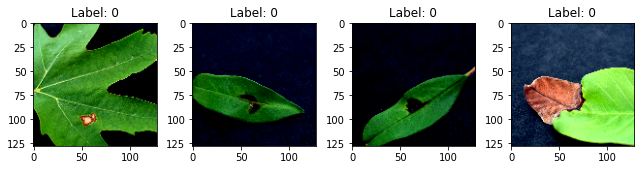

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[05:10:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[05:10:19] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.26150940510563 samples/sec                   batch loss = 1.0695486068725586 | accuracy = 0.3


Epoch[1] Batch[10] Speed: 1.270680557807723 samples/sec                   batch loss = 1.2253588438034058 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2690126116763238 samples/sec                   batch loss = 0.5623895525932312 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2619531039682674 samples/sec                   batch loss = 0.13733841478824615 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.27562903965538 samples/sec                   batch loss = 0.7814640998840332 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2729804073408983 samples/sec                   batch loss = 0.5918253660202026 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2696555695895033 samples/sec                   batch loss = 1.4008967876434326 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2746188120587096 samples/sec                   batch loss = 0.9104920029640198 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2688379395583516 samples/sec                   batch loss = 0.9421055912971497 | accuracy = 0.5833333333333334


Epoch[1] Batch[50] Speed: 1.2745158827764351 samples/sec                   batch loss = 0.34718355536460876 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2706377327213063 samples/sec                   batch loss = 0.4812949001789093 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.267379291740732 samples/sec                   batch loss = 0.387999027967453 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2642240136625162 samples/sec                   batch loss = 0.29679715633392334 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.271325881783901 samples/sec                   batch loss = 0.8251504898071289 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2643553961778027 samples/sec                   batch loss = 0.7393586039543152 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.274070854195149 samples/sec                   batch loss = 0.2754056453704834 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.270723482026845 samples/sec                   batch loss = 0.38049858808517456 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2703694920192716 samples/sec                   batch loss = 0.8028322458267212 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.2724837520926844 samples/sec                   batch loss = 0.39193451404571533 | accuracy = 0.6078947368421053


Epoch[1] Batch[100] Speed: 1.2692350523150815 samples/sec                   batch loss = 0.8814460039138794 | accuracy = 0.6125


Epoch[1] Batch[105] Speed: 1.2686034554840249 samples/sec                   batch loss = 0.4723449647426605 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.272818160044676 samples/sec                   batch loss = 0.519336462020874 | accuracy = 0.6181818181818182


Epoch[1] Batch[115] Speed: 1.268446445666327 samples/sec                   batch loss = 0.5553340315818787 | accuracy = 0.6152173913043478


Epoch[1] Batch[120] Speed: 1.2780372915160425 samples/sec                   batch loss = 0.6656265258789062 | accuracy = 0.6166666666666667


Epoch[1] Batch[125] Speed: 1.273430280381039 samples/sec                   batch loss = 0.8628929257392883 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.2736123103289487 samples/sec                   batch loss = 0.7458449602127075 | accuracy = 0.6173076923076923


Epoch[1] Batch[135] Speed: 1.2745956684665658 samples/sec                   batch loss = 0.4529716968536377 | accuracy = 0.6222222222222222


Epoch[1] Batch[140] Speed: 1.2742836509621223 samples/sec                   batch loss = 0.9930093288421631 | accuracy = 0.6196428571428572


Epoch[1] Batch[145] Speed: 1.2742911035240148 samples/sec                   batch loss = 0.7407354116439819 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.2737446844791231 samples/sec                   batch loss = 0.7400661706924438 | accuracy = 0.62


Epoch[1] Batch[155] Speed: 1.2745288569536972 samples/sec                   batch loss = 0.36762261390686035 | accuracy = 0.6209677419354839


Epoch[1] Batch[160] Speed: 1.266894075894715 samples/sec                   batch loss = 0.39933979511260986 | accuracy = 0.6203125


Epoch[1] Batch[165] Speed: 1.274811159108092 samples/sec                   batch loss = 2.2097666263580322 | accuracy = 0.6166666666666667


Epoch[1] Batch[170] Speed: 1.2808024558843782 samples/sec                   batch loss = 0.6790063381195068 | accuracy = 0.6220588235294118


Epoch[1] Batch[175] Speed: 1.273836366561607 samples/sec                   batch loss = 0.7198618054389954 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.2778187624366182 samples/sec                   batch loss = 0.7720941305160522 | accuracy = 0.6236111111111111


Epoch[1] Batch[185] Speed: 1.2786835818288271 samples/sec                   batch loss = 0.3320208191871643 | accuracy = 0.6283783783783784


Epoch[1] Batch[190] Speed: 1.2775226750311839 samples/sec                   batch loss = 0.7100686430931091 | accuracy = 0.6236842105263158


Epoch[1] Batch[195] Speed: 1.278707556327345 samples/sec                   batch loss = 0.54867023229599 | accuracy = 0.6205128205128205


Epoch[1] Batch[200] Speed: 1.2788238356522532 samples/sec                   batch loss = 0.7247781753540039 | accuracy = 0.62375


Epoch[1] Batch[205] Speed: 1.2764528261003205 samples/sec                   batch loss = 0.5771076083183289 | accuracy = 0.624390243902439


Epoch[1] Batch[210] Speed: 1.272806186287964 samples/sec                   batch loss = 0.5480402708053589 | accuracy = 0.6202380952380953


Epoch[1] Batch[215] Speed: 1.2668646112417326 samples/sec                   batch loss = 0.8417986035346985 | accuracy = 0.6209302325581395


Epoch[1] Batch[220] Speed: 1.2699108205121452 samples/sec                   batch loss = 0.42848360538482666 | accuracy = 0.6272727272727273


Epoch[1] Batch[225] Speed: 1.2732870517625468 samples/sec                   batch loss = 0.41145744919776917 | accuracy = 0.6277777777777778


Epoch[1] Batch[230] Speed: 1.2686643707945833 samples/sec                   batch loss = 0.40512874722480774 | accuracy = 0.6304347826086957


Epoch[1] Batch[235] Speed: 1.2717784421737133 samples/sec                   batch loss = 0.8172513246536255 | accuracy = 0.6308510638297873


Epoch[1] Batch[240] Speed: 1.2705157211138411 samples/sec                   batch loss = 0.5864608883857727 | accuracy = 0.6333333333333333


Epoch[1] Batch[245] Speed: 1.273963466718484 samples/sec                   batch loss = 0.46705910563468933 | accuracy = 0.6346938775510204


Epoch[1] Batch[250] Speed: 1.2728542758044041 samples/sec                   batch loss = 0.6295668482780457 | accuracy = 0.634


Epoch[1] Batch[255] Speed: 1.2722175291832039 samples/sec                   batch loss = 0.5279791355133057 | accuracy = 0.634313725490196


Epoch[1] Batch[260] Speed: 1.2700432915900703 samples/sec                   batch loss = 0.5429008603096008 | accuracy = 0.6375


Epoch[1] Batch[265] Speed: 1.276604927477873 samples/sec                   batch loss = 0.2933352589607239 | accuracy = 0.6424528301886793


Epoch[1] Batch[270] Speed: 1.268229649946061 samples/sec                   batch loss = 0.6187624931335449 | accuracy = 0.6398148148148148


Epoch[1] Batch[275] Speed: 1.2690999657709756 samples/sec                   batch loss = 0.2485373467206955 | accuracy = 0.6436363636363637


Epoch[1] Batch[280] Speed: 1.2690022451754597 samples/sec                   batch loss = 0.30330678820610046 | accuracy = 0.6473214285714286


Epoch[1] Batch[285] Speed: 1.2691543041644928 samples/sec                   batch loss = 0.7314345240592957 | accuracy = 0.6473684210526316


Epoch[1] Batch[290] Speed: 1.2701456920191105 samples/sec                   batch loss = 0.49051713943481445 | accuracy = 0.646551724137931


Epoch[1] Batch[295] Speed: 1.2692562732128791 samples/sec                   batch loss = 0.3554612696170807 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.2705010966895152 samples/sec                   batch loss = 0.3714486360549927 | accuracy = 0.65


Epoch[1] Batch[305] Speed: 1.2719455353216782 samples/sec                   batch loss = 0.6275866031646729 | accuracy = 0.65


Epoch[1] Batch[310] Speed: 1.2711716646853404 samples/sec                   batch loss = 0.7484046220779419 | accuracy = 0.6491935483870968


Epoch[1] Batch[315] Speed: 1.2683845923610164 samples/sec                   batch loss = 0.13109762966632843 | accuracy = 0.6515873015873016


Epoch[1] Batch[320] Speed: 1.2699026501241086 samples/sec                   batch loss = 0.22942683100700378 | accuracy = 0.653125


Epoch[1] Batch[325] Speed: 1.275974030912596 samples/sec                   batch loss = 0.5654699802398682 | accuracy = 0.6530769230769231


Epoch[1] Batch[330] Speed: 1.2765182854686352 samples/sec                   batch loss = 0.43919986486434937 | accuracy = 0.6537878787878788


Epoch[1] Batch[335] Speed: 1.2782373914632181 samples/sec                   batch loss = 0.33299723267555237 | accuracy = 0.6522388059701493


Epoch[1] Batch[340] Speed: 1.2750160638404187 samples/sec                   batch loss = 0.6988074779510498 | accuracy = 0.6514705882352941


Epoch[1] Batch[345] Speed: 1.2755462152034758 samples/sec                   batch loss = 0.6730169653892517 | accuracy = 0.6521739130434783


Epoch[1] Batch[350] Speed: 1.2687122437813898 samples/sec                   batch loss = 0.27669236063957214 | accuracy = 0.655


Epoch[1] Batch[355] Speed: 1.2792720938662678 samples/sec                   batch loss = 0.7598966956138611 | accuracy = 0.6556338028169014


Epoch[1] Batch[360] Speed: 1.2797204712136014 samples/sec                   batch loss = 0.6609127521514893 | accuracy = 0.6548611111111111


Epoch[1] Batch[365] Speed: 1.280664895982144 samples/sec                   batch loss = 0.46527013182640076 | accuracy = 0.6561643835616439


Epoch[1] Batch[370] Speed: 1.279869056365617 samples/sec                   batch loss = 0.1965671181678772 | accuracy = 0.6601351351351351


Epoch[1] Batch[375] Speed: 1.2780281400241311 samples/sec                   batch loss = 0.6592703461647034 | accuracy = 0.662


Epoch[1] Batch[380] Speed: 1.2784282020206024 samples/sec                   batch loss = 0.3955753743648529 | accuracy = 0.6618421052631579


Epoch[1] Batch[385] Speed: 1.2773404981845506 samples/sec                   batch loss = 0.7836000323295593 | accuracy = 0.6623376623376623


Epoch[1] Batch[390] Speed: 1.2764280620660005 samples/sec                   batch loss = 0.7909136414527893 | accuracy = 0.6608974358974359


Epoch[1] Batch[395] Speed: 1.2776477875700492 samples/sec                   batch loss = 0.868150532245636 | accuracy = 0.6632911392405063


Epoch[1] Batch[400] Speed: 1.273411625976261 samples/sec                   batch loss = 0.38959604501724243 | accuracy = 0.665625


Epoch[1] Batch[405] Speed: 1.278058223612593 samples/sec                   batch loss = 0.7601537704467773 | accuracy = 0.6660493827160494


Epoch[1] Batch[410] Speed: 1.2776223933853565 samples/sec                   batch loss = 0.4311853051185608 | accuracy = 0.6652439024390244


Epoch[1] Batch[415] Speed: 1.2805142690362707 samples/sec                   batch loss = 0.31737667322158813 | accuracy = 0.6668674698795181


Epoch[1] Batch[420] Speed: 1.2786440161266968 samples/sec                   batch loss = 0.31491464376449585 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2780774038565186 samples/sec                   batch loss = 0.2690367102622986 | accuracy = 0.67


Epoch[1] Batch[430] Speed: 1.2759802416885526 samples/sec                   batch loss = 0.594319224357605 | accuracy = 0.672093023255814


Epoch[1] Batch[435] Speed: 1.2819098767145143 samples/sec                   batch loss = 0.24419240653514862 | accuracy = 0.6741379310344827


Epoch[1] Batch[440] Speed: 1.2795437173969182 samples/sec                   batch loss = 0.32769107818603516 | accuracy = 0.6744318181818182


Epoch[1] Batch[445] Speed: 1.2742672943461828 samples/sec                   batch loss = 0.24045275151729584 | accuracy = 0.6730337078651686


Epoch[1] Batch[450] Speed: 1.2725070120855133 samples/sec                   batch loss = 0.21673676371574402 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.2770167348920902 samples/sec                   batch loss = 0.566106915473938 | accuracy = 0.6747252747252748


Epoch[1] Batch[460] Speed: 1.2772380039989208 samples/sec                   batch loss = 0.41600820422172546 | accuracy = 0.6755434782608696


Epoch[1] Batch[465] Speed: 1.2785729794223046 samples/sec                   batch loss = 0.3855130672454834 | accuracy = 0.6768817204301075


Epoch[1] Batch[470] Speed: 1.2755691993653941 samples/sec                   batch loss = 0.49931100010871887 | accuracy = 0.6776595744680851


Epoch[1] Batch[475] Speed: 1.2782982615382705 samples/sec                   batch loss = 0.5844770669937134 | accuracy = 0.6794736842105263


Epoch[1] Batch[480] Speed: 1.2788073622744414 samples/sec                   batch loss = 0.3781772255897522 | accuracy = 0.6786458333333333


Epoch[1] Batch[485] Speed: 1.2773097676509269 samples/sec                   batch loss = 0.3302289843559265 | accuracy = 0.6783505154639176


Epoch[1] Batch[490] Speed: 1.2804443925126296 samples/sec                   batch loss = 0.4256376624107361 | accuracy = 0.6775510204081633


Epoch[1] Batch[495] Speed: 1.2764105821496998 samples/sec                   batch loss = 0.12597395479679108 | accuracy = 0.6782828282828283


Epoch[1] Batch[500] Speed: 1.2856201744365723 samples/sec                   batch loss = 0.8343161344528198 | accuracy = 0.677


Epoch[1] Batch[505] Speed: 1.2841038380180922 samples/sec                   batch loss = 0.8385920524597168 | accuracy = 0.6772277227722773


Epoch[1] Batch[510] Speed: 1.281584282694435 samples/sec                   batch loss = 0.558005154132843 | accuracy = 0.6764705882352942


Epoch[1] Batch[515] Speed: 1.2781423483477763 samples/sec                   batch loss = 0.6759922504425049 | accuracy = 0.6771844660194175


Epoch[1] Batch[520] Speed: 1.279146663023264 samples/sec                   batch loss = 0.44392064213752747 | accuracy = 0.6783653846153846


Epoch[1] Batch[525] Speed: 1.2738581284875565 samples/sec                   batch loss = 0.8152264356613159 | accuracy = 0.6785714285714286


Epoch[1] Batch[530] Speed: 1.2877607351862408 samples/sec                   batch loss = 0.346314013004303 | accuracy = 0.6806603773584906


Epoch[1] Batch[535] Speed: 1.2819999951095582 samples/sec                   batch loss = 0.7023462057113647 | accuracy = 0.6813084112149532


Epoch[1] Batch[540] Speed: 1.278700441849832 samples/sec                   batch loss = 0.8186019659042358 | accuracy = 0.6824074074074075


Epoch[1] Batch[545] Speed: 1.2771879298045175 samples/sec                   batch loss = 0.35106322169303894 | accuracy = 0.6821100917431193


Epoch[1] Batch[550] Speed: 1.281841120982637 samples/sec                   batch loss = 0.9014145731925964 | accuracy = 0.6813636363636364


Epoch[1] Batch[555] Speed: 1.285821769172021 samples/sec                   batch loss = 0.5938417911529541 | accuracy = 0.6833333333333333


Epoch[1] Batch[560] Speed: 1.2757862805274722 samples/sec                   batch loss = 0.2804355025291443 | accuracy = 0.6852678571428571


Epoch[1] Batch[565] Speed: 1.2793271117318512 samples/sec                   batch loss = 0.3889821767807007 | accuracy = 0.684070796460177


Epoch[1] Batch[570] Speed: 1.2814960825389872 samples/sec                   batch loss = 0.4916316270828247 | accuracy = 0.6837719298245614


Epoch[1] Batch[575] Speed: 1.2854409008589749 samples/sec                   batch loss = 0.41632479429244995 | accuracy = 0.6826086956521739


Epoch[1] Batch[580] Speed: 1.283249537307187 samples/sec                   batch loss = 0.6087487936019897 | accuracy = 0.6814655172413793


Epoch[1] Batch[585] Speed: 1.2789316541533413 samples/sec                   batch loss = 0.6443613767623901 | accuracy = 0.6816239316239316


Epoch[1] Batch[590] Speed: 1.2803209789075234 samples/sec                   batch loss = 0.7051188945770264 | accuracy = 0.6817796610169492


Epoch[1] Batch[595] Speed: 1.2782231730489386 samples/sec                   batch loss = 0.3316631317138672 | accuracy = 0.6827731092436975


Epoch[1] Batch[600] Speed: 1.2786244290867195 samples/sec                   batch loss = 1.113223910331726 | accuracy = 0.6825


Epoch[1] Batch[605] Speed: 1.2825049904067538 samples/sec                   batch loss = 0.34539276361465454 | accuracy = 0.684297520661157


Epoch[1] Batch[610] Speed: 1.279432088021232 samples/sec                   batch loss = 0.6931111216545105 | accuracy = 0.6836065573770492


Epoch[1] Batch[615] Speed: 1.282577249114011 samples/sec                   batch loss = 0.9814037680625916 | accuracy = 0.682520325203252


Epoch[1] Batch[620] Speed: 1.2791072636987064 samples/sec                   batch loss = 0.5495936274528503 | accuracy = 0.6834677419354839


Epoch[1] Batch[625] Speed: 1.2873516508804361 samples/sec                   batch loss = 0.8838115930557251 | accuracy = 0.6836


Epoch[1] Batch[630] Speed: 1.2770690314785051 samples/sec                   batch loss = 0.4103847146034241 | accuracy = 0.6849206349206349


Epoch[1] Batch[635] Speed: 1.2828872597714231 samples/sec                   batch loss = 0.33199623227119446 | accuracy = 0.6846456692913386


Epoch[1] Batch[640] Speed: 1.2750197459462578 samples/sec                   batch loss = 0.26525062322616577 | accuracy = 0.684375


Epoch[1] Batch[645] Speed: 1.2786929376237273 samples/sec                   batch loss = 0.6658755540847778 | accuracy = 0.6841085271317829


Epoch[1] Batch[650] Speed: 1.2709483522238356 samples/sec                   batch loss = 0.30784153938293457 | accuracy = 0.685


Epoch[1] Batch[655] Speed: 1.2792219575923214 samples/sec                   batch loss = 0.47772762179374695 | accuracy = 0.6851145038167938


Epoch[1] Batch[660] Speed: 1.2778616836313563 samples/sec                   batch loss = 0.5299737453460693 | accuracy = 0.6859848484848485


Epoch[1] Batch[665] Speed: 1.2726595260490943 samples/sec                   batch loss = 0.2257145643234253 | accuracy = 0.6864661654135338


Epoch[1] Batch[670] Speed: 1.2735205638244809 samples/sec                   batch loss = 0.5755078196525574 | accuracy = 0.6880597014925374


Epoch[1] Batch[675] Speed: 1.2717554016124109 samples/sec                   batch loss = 0.36430788040161133 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2777545320212877 samples/sec                   batch loss = 1.3216012716293335 | accuracy = 0.6867647058823529


Epoch[1] Batch[685] Speed: 1.2737295988186816 samples/sec                   batch loss = 0.4744485318660736 | accuracy = 0.6864963503649635


Epoch[1] Batch[690] Speed: 1.272411178659868 samples/sec                   batch loss = 0.559400200843811 | accuracy = 0.6869565217391305


Epoch[1] Batch[695] Speed: 1.2719866162983535 samples/sec                   batch loss = 0.2863842248916626 | accuracy = 0.6877697841726619


Epoch[1] Batch[700] Speed: 1.277243157488365 samples/sec                   batch loss = 0.5880002379417419 | accuracy = 0.6885714285714286


Epoch[1] Batch[705] Speed: 1.2744296208968218 samples/sec                   batch loss = 0.34261664748191833 | accuracy = 0.6879432624113475


Epoch[1] Batch[710] Speed: 1.2757164340226919 samples/sec                   batch loss = 0.20606516301631927 | accuracy = 0.6880281690140845


Epoch[1] Batch[715] Speed: 1.2822084914323866 samples/sec                   batch loss = 0.2858021557331085 | accuracy = 0.6877622377622378


Epoch[1] Batch[720] Speed: 1.274352953472626 samples/sec                   batch loss = 0.8682426810264587 | accuracy = 0.6871527777777777


Epoch[1] Batch[725] Speed: 1.2737414932519218 samples/sec                   batch loss = 0.25788575410842896 | accuracy = 0.6872413793103448


Epoch[1] Batch[730] Speed: 1.2835905122789149 samples/sec                   batch loss = 0.521420955657959 | accuracy = 0.6866438356164384


Epoch[1] Batch[735] Speed: 1.2684256354313284 samples/sec                   batch loss = 1.1357085704803467 | accuracy = 0.6874149659863945


Epoch[1] Batch[740] Speed: 1.2797465345761292 samples/sec                   batch loss = 1.1854894161224365 | accuracy = 0.6875


Epoch[1] Batch[745] Speed: 1.2778620729524404 samples/sec                   batch loss = 0.37162941694259644 | accuracy = 0.6875838926174497


Epoch[1] Batch[750] Speed: 1.278070101665332 samples/sec                   batch loss = 0.6659097671508789 | accuracy = 0.6873333333333334


Epoch[1] Batch[755] Speed: 1.277003612814932 samples/sec                   batch loss = 0.9789550304412842 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.2775704406125863 samples/sec                   batch loss = 0.7536159157752991 | accuracy = 0.6881578947368421


Epoch[1] Batch[765] Speed: 1.278510816601787 samples/sec                   batch loss = 0.30907630920410156 | accuracy = 0.6882352941176471


Epoch[1] Batch[770] Speed: 1.2831255823970622 samples/sec                   batch loss = 0.4226572811603546 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.2744071618071389 samples/sec                   batch loss = 0.42242851853370667 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.2781958083610163 samples/sec                   batch loss = 0.471981018781662 | accuracy = 0.6903846153846154


Epoch[1] Batch[785] Speed: 1.2782562849140728 samples/sec                   batch loss = 1.3152536153793335 | accuracy = 0.6904458598726114


[Epoch 1] training: accuracy=0.6906725888324873
[Epoch 1] time cost: 645.5793161392212
[Epoch 1] validation: validation accuracy=0.7222222222222222


Epoch[2] Batch[5] Speed: 1.2729900662224019 samples/sec                   batch loss = 0.4151361286640167 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.271286481102805 samples/sec                   batch loss = 0.614632248878479 | accuracy = 0.6


Epoch[2] Batch[15] Speed: 1.2766748713106686 samples/sec                   batch loss = 0.24828022718429565 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2765449955964063 samples/sec                   batch loss = 0.29063770174980164 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.2742787148976888 samples/sec                   batch loss = 1.1257866621017456 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2737148036141848 samples/sec                   batch loss = 0.1985999047756195 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2728286855491309 samples/sec                   batch loss = 0.4590804874897003 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2758991181906787 samples/sec                   batch loss = 0.4041716754436493 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.278074093519508 samples/sec                   batch loss = 0.3383863568305969 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2784893825479493 samples/sec                   batch loss = 0.22912101447582245 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2659107166032348 samples/sec                   batch loss = 0.5523272156715393 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2661544305136798 samples/sec                   batch loss = 0.6350432634353638 | accuracy = 0.7041666666666667


Epoch[2] Batch[65] Speed: 1.2748242361658049 samples/sec                   batch loss = 0.4738656282424927 | accuracy = 0.7038461538461539


Epoch[2] Batch[70] Speed: 1.2736351281612535 samples/sec                   batch loss = 0.7069554924964905 | accuracy = 0.7071428571428572


Epoch[2] Batch[75] Speed: 1.276811866853456 samples/sec                   batch loss = 0.09550927579402924 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2664972791456321 samples/sec                   batch loss = 0.5889535546302795 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.2645665800392805 samples/sec                   batch loss = 0.48304304480552673 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.2639426668462697 samples/sec                   batch loss = 0.6513803601264954 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2760193515574774 samples/sec                   batch loss = 0.435975044965744 | accuracy = 0.7105263157894737


Epoch[2] Batch[100] Speed: 1.276553543073369 samples/sec                   batch loss = 0.6290527582168579 | accuracy = 0.7025


Epoch[2] Batch[105] Speed: 1.2771117078890264 samples/sec                   batch loss = 0.38389772176742554 | accuracy = 0.7071428571428572


Epoch[2] Batch[110] Speed: 1.2805694915440529 samples/sec                   batch loss = 0.22166985273361206 | accuracy = 0.7181818181818181


Epoch[2] Batch[115] Speed: 1.2768237217505343 samples/sec                   batch loss = 0.640569269657135 | accuracy = 0.7217391304347827


Epoch[2] Batch[120] Speed: 1.275305755502322 samples/sec                   batch loss = 0.7025218605995178 | accuracy = 0.7145833333333333


Epoch[2] Batch[125] Speed: 1.2754028980624343 samples/sec                   batch loss = 0.22806291282176971 | accuracy = 0.722


Epoch[2] Batch[130] Speed: 1.270530345874847 samples/sec                   batch loss = 0.4322342276573181 | accuracy = 0.7230769230769231


Epoch[2] Batch[135] Speed: 1.2657336505787204 samples/sec                   batch loss = 0.5082837343215942 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.2710147888700933 samples/sec                   batch loss = 0.2631570100784302 | accuracy = 0.7232142857142857


Epoch[2] Batch[145] Speed: 1.2662415826812201 samples/sec                   batch loss = 0.38788580894470215 | accuracy = 0.7189655172413794


Epoch[2] Batch[150] Speed: 1.2732585451874603 samples/sec                   batch loss = 1.090603232383728 | accuracy = 0.7166666666666667


Epoch[2] Batch[155] Speed: 1.2711124344592273 samples/sec                   batch loss = 0.48864197731018066 | accuracy = 0.7209677419354839


Epoch[2] Batch[160] Speed: 1.2657926670829336 samples/sec                   batch loss = 0.2933982312679291 | accuracy = 0.7234375


Epoch[2] Batch[165] Speed: 1.2693063035676755 samples/sec                   batch loss = 0.6290081739425659 | accuracy = 0.7212121212121212


Epoch[2] Batch[170] Speed: 1.2714204919243444 samples/sec                   batch loss = 0.28902003169059753 | accuracy = 0.7294117647058823


Epoch[2] Batch[175] Speed: 1.2698124944701388 samples/sec                   batch loss = 0.32485803961753845 | accuracy = 0.7357142857142858


Epoch[2] Batch[180] Speed: 1.2741354888984866 samples/sec                   batch loss = 0.39901337027549744 | accuracy = 0.7375


Epoch[2] Batch[185] Speed: 1.2646041354593163 samples/sec                   batch loss = 1.0105725526809692 | accuracy = 0.7351351351351352


Epoch[2] Batch[190] Speed: 1.2670652467139198 samples/sec                   batch loss = 0.4148660898208618 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.271246312262478 samples/sec                   batch loss = 0.3807905912399292 | accuracy = 0.7435897435897436


Epoch[2] Batch[200] Speed: 1.2741852272515828 samples/sec                   batch loss = 0.6400558948516846 | accuracy = 0.74125


Epoch[2] Batch[205] Speed: 1.268238086429725 samples/sec                   batch loss = 0.19991713762283325 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.271787407973414 samples/sec                   batch loss = 0.7549437880516052 | accuracy = 0.7440476190476191


Epoch[2] Batch[215] Speed: 1.2720553798333332 samples/sec                   batch loss = 0.3720039129257202 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2653439742436392 samples/sec                   batch loss = 0.3944312036037445 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2664125772164312 samples/sec                   batch loss = 0.22693577408790588 | accuracy = 0.7444444444444445


Epoch[2] Batch[230] Speed: 1.2670161583449993 samples/sec                   batch loss = 0.10647278279066086 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2699396580161704 samples/sec                   batch loss = 0.20206734538078308 | accuracy = 0.75


Epoch[2] Batch[240] Speed: 1.2788190593037558 samples/sec                   batch loss = 0.5995831489562988 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.2735803087297466 samples/sec                   batch loss = 0.7184179425239563 | accuracy = 0.746938775510204


Epoch[2] Batch[250] Speed: 1.26752856794461 samples/sec                   batch loss = 0.27209028601646423 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.2717266743831899 samples/sec                   batch loss = 0.5280911922454834 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.2661734462462444 samples/sec                   batch loss = 0.4728860557079315 | accuracy = 0.75


Epoch[2] Batch[265] Speed: 1.2634081292643335 samples/sec                   batch loss = 0.35271331667900085 | accuracy = 0.7528301886792453


Epoch[2] Batch[270] Speed: 1.2671107022989792 samples/sec                   batch loss = 0.5429863333702087 | accuracy = 0.7546296296296297


Epoch[2] Batch[275] Speed: 1.2642922262665857 samples/sec                   batch loss = 0.4118843078613281 | accuracy = 0.7572727272727273


Epoch[2] Batch[280] Speed: 1.2674902640896837 samples/sec                   batch loss = 0.5884864330291748 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.2660494242669655 samples/sec                   batch loss = 0.3724081814289093 | accuracy = 0.7552631578947369


Epoch[2] Batch[290] Speed: 1.2710173887061593 samples/sec                   batch loss = 0.7149066925048828 | accuracy = 0.7560344827586207


Epoch[2] Batch[295] Speed: 1.2624796656627861 samples/sec                   batch loss = 0.5908852219581604 | accuracy = 0.7559322033898305


Epoch[2] Batch[300] Speed: 1.2769161391917332 samples/sec                   batch loss = 0.8256432414054871 | accuracy = 0.7541666666666667


Epoch[2] Batch[305] Speed: 1.270289657444913 samples/sec                   batch loss = 0.2559318244457245 | accuracy = 0.7549180327868853


Epoch[2] Batch[310] Speed: 1.2660862079127218 samples/sec                   batch loss = 0.6200748085975647 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.2623898959544375 samples/sec                   batch loss = 0.48150205612182617 | accuracy = 0.7555555555555555


Epoch[2] Batch[320] Speed: 1.2647124295651992 samples/sec                   batch loss = 0.5588570237159729 | accuracy = 0.75390625


Epoch[2] Batch[325] Speed: 1.2642239183986632 samples/sec                   batch loss = 0.2658950388431549 | accuracy = 0.7538461538461538


Epoch[2] Batch[330] Speed: 1.2698778512372049 samples/sec                   batch loss = 0.3407386541366577 | accuracy = 0.7560606060606061


Epoch[2] Batch[335] Speed: 1.2635333471506587 samples/sec                   batch loss = 0.28231847286224365 | accuracy = 0.7559701492537313


Epoch[2] Batch[340] Speed: 1.2674874871502055 samples/sec                   batch loss = 0.7714059352874756 | accuracy = 0.7566176470588235


Epoch[2] Batch[345] Speed: 1.2680089990672767 samples/sec                   batch loss = 0.20556379854679108 | accuracy = 0.7594202898550725


Epoch[2] Batch[350] Speed: 1.2686720455793508 samples/sec                   batch loss = 0.5330787301063538 | accuracy = 0.7585714285714286


Epoch[2] Batch[355] Speed: 1.2611317100070343 samples/sec                   batch loss = 0.6822935938835144 | accuracy = 0.7577464788732394


Epoch[2] Batch[360] Speed: 1.2651145001730961 samples/sec                   batch loss = 0.5198279023170471 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.2677256778810748 samples/sec                   batch loss = 0.4524211883544922 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.2676147600833652 samples/sec                   batch loss = 0.5950104594230652 | accuracy = 0.7567567567567568


Epoch[2] Batch[375] Speed: 1.2589044753151497 samples/sec                   batch loss = 0.7579355239868164 | accuracy = 0.7566666666666667


Epoch[2] Batch[380] Speed: 1.269299869500676 samples/sec                   batch loss = 0.4098622500896454 | accuracy = 0.7578947368421053


Epoch[2] Batch[385] Speed: 1.266168286141745 samples/sec                   batch loss = 0.5984198451042175 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.267399780426967 samples/sec                   batch loss = 0.22954247891902924 | accuracy = 0.757051282051282


Epoch[2] Batch[395] Speed: 1.2788728683947985 samples/sec                   batch loss = 0.6091456413269043 | accuracy = 0.7569620253164557


Epoch[2] Batch[400] Speed: 1.2745092989666178 samples/sec                   batch loss = 0.3970019817352295 | accuracy = 0.7575


Epoch[2] Batch[405] Speed: 1.276965122944272 samples/sec                   batch loss = 0.42861407995224 | accuracy = 0.7580246913580246


Epoch[2] Batch[410] Speed: 1.2758619562057296 samples/sec                   batch loss = 0.04333142936229706 | accuracy = 0.7591463414634146


Epoch[2] Batch[415] Speed: 1.2715644573774458 samples/sec                   batch loss = 0.7080539464950562 | accuracy = 0.7590361445783133


Epoch[2] Batch[420] Speed: 1.272410020640277 samples/sec                   batch loss = 0.6905948519706726 | accuracy = 0.7577380952380952


Epoch[2] Batch[425] Speed: 1.2749008634289247 samples/sec                   batch loss = 0.4368852376937866 | accuracy = 0.7564705882352941


Epoch[2] Batch[430] Speed: 1.265519117525815 samples/sec                   batch loss = 0.30344295501708984 | accuracy = 0.7552325581395349


Epoch[2] Batch[435] Speed: 1.269753871329581 samples/sec                   batch loss = 0.8551093339920044 | accuracy = 0.7540229885057471


Epoch[2] Batch[440] Speed: 1.2741378112254371 samples/sec                   batch loss = 0.6372660994529724 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.2690410244358166 samples/sec                   batch loss = 0.46102920174598694 | accuracy = 0.755056179775281


Epoch[2] Batch[450] Speed: 1.2717005510833572 samples/sec                   batch loss = 0.5872764587402344 | accuracy = 0.7555555555555555


Epoch[2] Batch[455] Speed: 1.2745078466647857 samples/sec                   batch loss = 0.2618178725242615 | accuracy = 0.7571428571428571


Epoch[2] Batch[460] Speed: 1.2702404150968367 samples/sec                   batch loss = 0.304316908121109 | accuracy = 0.7565217391304347


Epoch[2] Batch[465] Speed: 1.2705390054315089 samples/sec                   batch loss = 0.44129714369773865 | accuracy = 0.7564516129032258


Epoch[2] Batch[470] Speed: 1.2715832504544884 samples/sec                   batch loss = 0.6852713823318481 | accuracy = 0.7563829787234042


Epoch[2] Batch[475] Speed: 1.2705633490397892 samples/sec                   batch loss = 0.22060942649841309 | accuracy = 0.7563157894736842


Epoch[2] Batch[480] Speed: 1.267135488928851 samples/sec                   batch loss = 0.5153210759162903 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2623788774837081 samples/sec                   batch loss = 0.34222352504730225 | accuracy = 0.7561855670103093


Epoch[2] Batch[490] Speed: 1.27005502113047 samples/sec                   batch loss = 0.4358436167240143 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.2716706696578373 samples/sec                   batch loss = 0.25120896100997925 | accuracy = 0.7575757575757576


Epoch[2] Batch[500] Speed: 1.2738479728295833 samples/sec                   batch loss = 0.463076651096344 | accuracy = 0.7565


Epoch[2] Batch[505] Speed: 1.2732077196814722 samples/sec                   batch loss = 0.4613661766052246 | accuracy = 0.7564356435643564


Epoch[2] Batch[510] Speed: 1.2734407193538106 samples/sec                   batch loss = 0.3785804212093353 | accuracy = 0.7553921568627451


Epoch[2] Batch[515] Speed: 1.2754921038650935 samples/sec                   batch loss = 0.4419420063495636 | accuracy = 0.7577669902912622


Epoch[2] Batch[520] Speed: 1.2714554684840433 samples/sec                   batch loss = 0.45686206221580505 | accuracy = 0.7567307692307692


Epoch[2] Batch[525] Speed: 1.2812719658523308 samples/sec                   batch loss = 0.7494773864746094 | accuracy = 0.7561904761904762


Epoch[2] Batch[530] Speed: 1.2794045739821402 samples/sec                   batch loss = 0.7365872859954834 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.2736995252670127 samples/sec                   batch loss = 0.5602098703384399 | accuracy = 0.7560747663551401


Epoch[2] Batch[540] Speed: 1.2723332100477007 samples/sec                   batch loss = 0.38080573081970215 | accuracy = 0.7550925925925925


Epoch[2] Batch[545] Speed: 1.2706909517471605 samples/sec                   batch loss = 0.47116386890411377 | accuracy = 0.755045871559633


Epoch[2] Batch[550] Speed: 1.2685789950763708 samples/sec                   batch loss = 0.20498548448085785 | accuracy = 0.7559090909090909


Epoch[2] Batch[555] Speed: 1.2730204926572164 samples/sec                   batch loss = 0.36884695291519165 | accuracy = 0.7558558558558559


Epoch[2] Batch[560] Speed: 1.276742782447642 samples/sec                   batch loss = 0.8821185827255249 | accuracy = 0.7553571428571428


Epoch[2] Batch[565] Speed: 1.269594847283562 samples/sec                   batch loss = 0.3881814181804657 | accuracy = 0.7561946902654867


Epoch[2] Batch[570] Speed: 1.2673512405484326 samples/sec                   batch loss = 0.5306784510612488 | accuracy = 0.756578947368421


Epoch[2] Batch[575] Speed: 1.2683824827422594 samples/sec                   batch loss = 0.5051965117454529 | accuracy = 0.7556521739130435


Epoch[2] Batch[580] Speed: 1.2690380487155477 samples/sec                   batch loss = 0.2514667510986328 | accuracy = 0.7547413793103448


Epoch[2] Batch[585] Speed: 1.2778395900485628 samples/sec                   batch loss = 0.5035306215286255 | accuracy = 0.7551282051282051


Epoch[2] Batch[590] Speed: 1.2686968933319973 samples/sec                   batch loss = 1.0117652416229248 | accuracy = 0.7563559322033898


Epoch[2] Batch[595] Speed: 1.2776831075972463 samples/sec                   batch loss = 0.29667696356773376 | accuracy = 0.7563025210084033


Epoch[2] Batch[600] Speed: 1.2706683355224064 samples/sec                   batch loss = 0.29118046164512634 | accuracy = 0.7554166666666666


Epoch[2] Batch[605] Speed: 1.2741898722765843 samples/sec                   batch loss = 0.2568255066871643 | accuracy = 0.756198347107438


Epoch[2] Batch[610] Speed: 1.2750129631362073 samples/sec                   batch loss = 0.6683247089385986 | accuracy = 0.7561475409836066


Epoch[2] Batch[615] Speed: 1.2775993351725796 samples/sec                   batch loss = 0.6987882852554321 | accuracy = 0.7552845528455284


Epoch[2] Batch[620] Speed: 1.2773514876267067 samples/sec                   batch loss = 0.5965859889984131 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.2724959128127395 samples/sec                   batch loss = 0.9402632117271423 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.2756934445545465 samples/sec                   batch loss = 0.6357440948486328 | accuracy = 0.7551587301587301


Epoch[2] Batch[635] Speed: 1.2703359218009538 samples/sec                   batch loss = 0.2404574453830719 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2729193666000789 samples/sec                   batch loss = 0.2782896161079407 | accuracy = 0.755078125


Epoch[2] Batch[645] Speed: 1.2633321162268656 samples/sec                   batch loss = 0.45607495307922363 | accuracy = 0.7542635658914729


Epoch[2] Batch[650] Speed: 1.2661582527256163 samples/sec                   batch loss = 0.2656616270542145 | accuracy = 0.7561538461538462


Epoch[2] Batch[655] Speed: 1.2723617716975386 samples/sec                   batch loss = 0.30720606446266174 | accuracy = 0.7549618320610687


Epoch[2] Batch[660] Speed: 1.2675845915014372 samples/sec                   batch loss = 0.2667520046234131 | accuracy = 0.7545454545454545


Epoch[2] Batch[665] Speed: 1.270061847438141 samples/sec                   batch loss = 0.38041284680366516 | accuracy = 0.7545112781954887


Epoch[2] Batch[670] Speed: 1.265965164334907 samples/sec                   batch loss = 0.47391438484191895 | accuracy = 0.755223880597015


Epoch[2] Batch[675] Speed: 1.2669282298211597 samples/sec                   batch loss = 0.5618330240249634 | accuracy = 0.7555555555555555


Epoch[2] Batch[680] Speed: 1.2707990395467388 samples/sec                   batch loss = 0.6191223859786987 | accuracy = 0.7558823529411764


Epoch[2] Batch[685] Speed: 1.2678432259525687 samples/sec                   batch loss = 0.38406509160995483 | accuracy = 0.7565693430656935


Epoch[2] Batch[690] Speed: 1.2645837370610222 samples/sec                   batch loss = 0.16161049902439117 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.2655347730186965 samples/sec                   batch loss = 0.1984633207321167 | accuracy = 0.7586330935251798


Epoch[2] Batch[700] Speed: 1.2660762713405664 samples/sec                   batch loss = 0.29150375723838806 | accuracy = 0.7575


Epoch[2] Batch[705] Speed: 1.2653095239693388 samples/sec                   batch loss = 0.7669296860694885 | accuracy = 0.7578014184397163


Epoch[2] Batch[710] Speed: 1.2697544479242768 samples/sec                   batch loss = 0.3676455318927765 | accuracy = 0.7577464788732394


Epoch[2] Batch[715] Speed: 1.2677395679192345 samples/sec                   batch loss = 0.4822823405265808 | accuracy = 0.759090909090909


Epoch[2] Batch[720] Speed: 1.2657511257661498 samples/sec                   batch loss = 0.22225622832775116 | accuracy = 0.7600694444444445


Epoch[2] Batch[725] Speed: 1.267006781272526 samples/sec                   batch loss = 0.313554048538208 | accuracy = 0.7606896551724138


Epoch[2] Batch[730] Speed: 1.2711777324836093 samples/sec                   batch loss = 0.3023397624492645 | accuracy = 0.7613013698630137


Epoch[2] Batch[735] Speed: 1.2672870051236955 samples/sec                   batch loss = 0.23302581906318665 | accuracy = 0.7619047619047619


Epoch[2] Batch[740] Speed: 1.2715798772971911 samples/sec                   batch loss = 0.34528160095214844 | accuracy = 0.7611486486486486


Epoch[2] Batch[745] Speed: 1.273887338996973 samples/sec                   batch loss = 0.41637542843818665 | accuracy = 0.7610738255033557


Epoch[2] Batch[750] Speed: 1.2705932746743887 samples/sec                   batch loss = 0.2542496919631958 | accuracy = 0.761


Epoch[2] Batch[755] Speed: 1.2608316496909624 samples/sec                   batch loss = 0.3025834262371063 | accuracy = 0.7609271523178808


Epoch[2] Batch[760] Speed: 1.271144408464802 samples/sec                   batch loss = 0.6323633193969727 | accuracy = 0.7601973684210527


Epoch[2] Batch[765] Speed: 1.2702359911665335 samples/sec                   batch loss = 0.4087720513343811 | accuracy = 0.7604575163398692


Epoch[2] Batch[770] Speed: 1.2730143106606615 samples/sec                   batch loss = 0.6294814348220825 | accuracy = 0.7613636363636364


Epoch[2] Batch[775] Speed: 1.2667108050467548 samples/sec                   batch loss = 0.23835070431232452 | accuracy = 0.7609677419354839


Epoch[2] Batch[780] Speed: 1.2719191137483006 samples/sec                   batch loss = 0.6518834233283997 | accuracy = 0.760576923076923


Epoch[2] Batch[785] Speed: 1.2680688030142417 samples/sec                   batch loss = 0.8600552678108215 | accuracy = 0.7598726114649682


[Epoch 2] training: accuracy=0.7607868020304569
[Epoch 2] time cost: 638.2848010063171
[Epoch 2] validation: validation accuracy=0.7566666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7666666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)